In [1]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from IPython.display import HTML, display
import json
from collections import Counter
import pandas as pd
import numpy as np
from utilities import *

register_matplotlib_converters()
pd.set_option('display.float_format', '{:.0f}'.format)
pd.set_option('display.max_colwidth', 100)
%matplotlib inline


ModuleNotFoundError: No module named 'ebmdatalab'

In [3]:
df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_rate.csv', parse_dates=['date'])

def calculate_rate(df, value_col, population_col, rate_per=1000):
    num_per_thousand = (df[value_col]/df[population_col])*rate_per
    return num_per_thousand

df['rate'] = calculate_rate(df, 'doac', 'population')

codelist = pd.read_csv('../codelists/opensafely-mechanical-or-artificial-valves.csv')


## DOAC Use in Patients with Mechanical Heart Valves


### Total Number

In [72]:
population = df.groupby(by='date')[['population']].sum().reset_index()
events = df.groupby(by='date')[['doac']].sum().reset_index()
total_df = df.groupby(by='date')[['rate']].mean().reset_index()

total_df = total_df.merge(events, on='date').merge(population, on='date')

def redact_small_numbers(df, n, numerator, denominator, rate_column):
    """
    Takes counts df as input and suppresses low numbers.  Sequentially redacts
    low numbers from numerator and denominator until count of redcted values >=n.
    Rates corresponding to redacted values are also redacted.
    
    df: input df
    n: threshold for low number suppression
    numerator: numerator column to be redacted
    denominator: denominator column to be redacted
    """
    
    def suppress_column(column):    
        suppressed_count = column[column<=n].sum()
        
        #if 0 dont need to suppress anything
        if suppressed_count == 0:
            pass
        
        else:
            df.loc[df[column.name]<=n, column.name] = np.nan
            

            while suppressed_count <=n:
                suppressed_count += column.min()
                column.iloc[column.idxmin()] = np.nan   
        return column
    
    
    for column in [numerator, denominator]:
        df[column] = suppress_column(df[column])
    
    df.loc[(df[numerator].isna())| (df[denominator].isna()), rate_column] = np.nan
    
    return df    

total_df = redact_small_numbers(total_df, 10, 'doac', 'population', 'rate')


def plot_measures(df, title,column_to_plot, filename,category=False, y_label='Rate per 1000', interactive=True):

    if interactive:

        fig = go.Figure()

        if category:
            for unique_category in df[category].unique():

                df_subset = df[df[category] == unique_category]
                fig.add_trace(go.Scatter(
                    x=df_subset['date'], y=df_subset[column_to_plot], name=unique_category))

        else:
            fig.add_trace(go.Scatter(
                x=df['date'], y=df[column_to_plot]))

        # Set title
        fig.update_layout(
            title_text=title,
            hovermode='x',
            title_x=0.5,
            yaxis=dict(
            range=[0, 7000]
        )


        )

        fig.update_yaxes(title=y_label)
        fig.update_xaxes(title="Date")

        # Add range slider
        fig.update_layout(
            xaxis=go.layout.XAxis(
                rangeselector=dict(
                    buttons=list([
                        dict(count=1,
                            label="1m",
                            step="month",
                            stepmode="backward"),
                        dict(count=6,
                            label="6m",
                            step="month",
                            stepmode="backward"),

                        dict(count=1,
                            label="1y",
                            step="year",
                            stepmode="backward"),
                        dict(step="all")
                    ])
                ),
                rangeslider=dict(
                    visible=True
                ),
                type="date"
            )
        )

        fig.show()

    else:

        if category:
            for unique_category in df[category].unique():

                df_subset = df[df[category] == unique_category]

                plt.plot(df_subset['date'], df_subset[column_to_plot], marker='o')
        else:
            plt.plot(df['date'], df[column_to_plot])

        plt.ylabel(y_label)
        plt.xlabel('Date')
        plt.ylim(bottom=0, top=df[column_to_plot].max() + df[column_to_plot].max()* 0.1)
        plt.xticks(rotation='vertical')
        plt.title(title)

        if category:
            plt.legend(df[category].unique(), bbox_to_anchor=(
                1.04, 1), loc="upper left")

        else:
            pass
        plt.savefig(f'../output/measure_{filename}.jpeg')
        plt.show()
        
        plt.clf()

         date        rate    doac  population
0  2018-09-01  199.996160  3000.0       15000
1  2018-10-01  199.935204  3000.0       15000
2  2018-11-01  200.025522  3000.0       15000
3  2018-12-01  200.006149  3000.0       15000
4  2019-01-01  200.076851  3000.0       15000
5  2019-02-01  199.945855  3000.0       15000
6  2019-03-01  200.032068  3000.0       15000
7  2019-04-01  199.996672  3000.0       15000
8  2019-05-01  200.056408  3000.0       15000
9  2019-06-01  200.048885  3000.0       15000
10 2019-07-01  200.030023  3000.0       15000
11 2019-08-01  200.024762  3000.0       15000
12 2019-09-01  200.031428  3000.0       15000
13 2019-10-01  200.002531  3000.0       15000
14 2019-11-01  199.778214  3000.0       15000
15 2019-12-01  199.958561  3000.0       15000
16 2020-01-01  200.072716  3000.0       15000
17 2020-02-01  199.869129  3000.0       15000
18 2020-03-01  200.082448  3000.0       15000
19 2020-04-01  199.922002  3000.0       15000
20 2020-05-01  199.928872  3000.0 

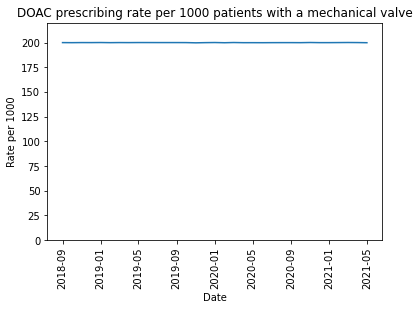

<Figure size 432x288 with 0 Axes>

In [70]:
plot_measures(total_df, title='DOAC prescribing rate per 1000 patients with a mechanical valve', column_to_plot='rate', category=False, y_label='Rate per 1000', interactive=False, filename="total")


### STP Breakdown

In [71]:
df_stp = pd.read_csv('../output/measure_stp_rate.csv', parse_dates=['date'])

df_stp['rate'] = calculate_rate(df_stp, 'doac', 'population')

df_stp = redact_small_numbers(df_stp, 10, 'doac', 'population', 'rate')

deciles_chart(df_stp, period_column='date', column='rate', title='Decile chart',ylabel='rate per 1000', interactive=False)
plt.tight_layout()
plt.savefig('../output/measure_stp.jpeg')

       stp   doac  population     value       date
0     STP1  292.0        1451  0.201241 2018-09-01
1    STP10  275.0        1427  0.192712 2018-09-01
2     STP2  321.0        1503  0.213573 2018-09-01
3     STP3  285.0        1539  0.185185 2018-09-01
4     STP4  304.0        1526  0.199214 2018-09-01
..     ...    ...         ...       ...        ...
325   STP5  286.0        1503  0.190286 2021-05-01
326   STP6  302.0        1470  0.205442 2021-05-01
327   STP7  274.0        1472  0.186141 2021-05-01
328   STP8  344.0        1553  0.221507 2021-05-01
329   STP9  277.0        1461  0.189596 2021-05-01

[330 rows x 5 columns]


TypeError: redact_small_numbers() missing 3 required positional arguments: 'numerator', 'denominator', and 'rate_column'

### Mechanical Valve Type

Mechanical valve type of those with mechanical valve currently prescribed a DOAC

In [159]:
def group_low_values_mv(df, value_col, population_col, term_col):
    
    df = df[df[value_col] > 0]
    suppressed_count = df.loc[df[value_col]<=5, value_col].sum()
    population_suppressed_count = df.loc[df[value_col]<=5, population_col].sum()
    
    if suppressed_count == 0:
        pass

    else:
        df.loc[df[value_col] <=5, value_col]  = np.nan

        while suppressed_count <=5:
            suppressed_count += df[value_col].min()
            df.loc[df[value_col].idxmin(), value_col] = np.nan 
            
            population_suppressed_count += df.loc[df[value_col].idxmin(), population_col]
   
        df = df[df[value_col].notnull()]

        other_row = {'mechanical_valve_code':'Other', 'doac_3_months':suppressed_count, 'population':population_suppressed_count, 'term':'-'}
        df = df.append(other_row, ignore_index=True)
    
    
    return df

In [160]:
valve_type_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_valve_code_rate.csv', parse_dates=['date'])


valve_type_df_now = valve_type_df[valve_type_df['date']== '2021-05-01']
valve_type_df_now = valve_type_df_now.drop('value', axis=1)

valve_type_df_now = valve_type_df_now.merge(codelist, left_on='mechanical_valve_code', right_on='code', how='left')
valve_type_df_now = valve_type_df_now.drop(columns=['code', 'date'])
valve_type_df_now = group_low_values_mv(valve_type_df_now, 'doac_3_months', 'population', 'term')
valve_type_df_now.to_csv('../output/current_doac_valve_type.csv')

0.0


In [161]:
valve_type_df_now

,mechanical_valve_code,doac_3_months,population,term
0,NaN,2412.0,12000,NaN
1,174920003.0,588.0,3000,Prosthetic mitral valve replacement (& [Bjork ...


### Demographic breakdown

#### Sex

In [193]:
def group_low_values_dems(df, value_col, population_col, demographic):
    
    df = df[df[value_col] > 0]
    suppressed_count = df.loc[df[value_col]<=5, value_col].sum()
    population_suppressed_count = df.loc[df[value_col]<=5, population_col].sum()
   
    if suppressed_count == 0:
        pass

    else:
        df.loc[df[value_col] <=5, value_col]  = np.nan

        while suppressed_count <=5:
            suppressed_count += df[value_col].min()
            df.loc[df[value_col].idxmin(), value_col] = np.nan 
            
            population_suppressed_count += df.loc[df[value_col].idxmin(), population_col]
   
        df = df[df[value_col].notnull()]

        other_row = {demographic:'Other', 'doac_3_months':suppressed_count, 'population':population_suppressed_count,}
        df = df.append(other_row, ignore_index=True)
    
    
    return df

In [194]:
sex_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_sex_rate.csv', parse_dates=['date'])

sex_df_now = sex_df[sex_df['date'] == '2021-05-01']
sex_df_now = sex_df_now.drop(['value', 'date'], axis=1)
sex_df_now = group_low_values_dems(sex_df_now, 'doac_3_months', 'population', 'sex')
sex_df_now.to_csv('../output/current_doac_sex.csv')
sex_df_now


,sex,doac_3_months,population,date
96,F,1531.0,7522,2021-05-01
97,M,1446.0,7335,2021-05-01
98,U,23.0,143,2021-05-01


#### Ethnicity

In [195]:
ethnicity_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_ethnicity_rate.csv', parse_dates=['date'])
ethnicity_df_now = ethnicity_df[ethnicity_df['date'] == '2021-05-01']
ethnicity_df_now = ethnicity_df_now.drop(['value', 'date'], axis=1)
ethnicity_df_now = group_low_values_dems(ethnicity_df_now, 'doac_3_months', 'population', 'eth2001')
ethnicity_df_now.to_csv('../output/current_doac_ethnicity.csv')
ethnicity_df_now


     eth2001  doac_3_months  population     value       date
0        NaN         2700.0       13482  0.200267 2018-09-01
1        1.0          158.0         786  0.201018 2018-09-01
2        2.0           73.0         361  0.202216 2018-09-01
3        3.0           38.0         187  0.203209 2018-09-01
4        4.0           17.0         103  0.165049 2018-09-01
..       ...            ...         ...       ...        ...
292      4.0           24.0         107  0.224299 2021-05-01
293      5.0           17.0          57  0.298246 2021-05-01
294      6.0            8.0          38  0.210526 2021-05-01
295      7.0            1.0          12  0.083333 2021-05-01
296      8.0            0.0           5  0.000000 2021-05-01

[297 rows x 5 columns]


/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


KeyError: 'doac_3_months'

#### Age Band

In [188]:
age_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_age_rate.csv', parse_dates=['date'])

age_df_now = age_df[age_df['date'] == '2021-05-01']
age_df_now = age_df_now.drop(['value', 'date'], axis=1)
age_df_now = group_low_values_dems(age_df_now, 'doac_3_months', 'population', 'age_band')
age_df_now.to_csv('../output/current_doac_age.csv')
age_df_now

,age_band,doac_3_months,population,date
0,0-19,357.0,1867,2021-05-01 00:00:00
1,20-29,370.0,1878,2021-05-01 00:00:00
2,30-39,387.0,1877,2021-05-01 00:00:00
3,40-49,392.0,1904,2021-05-01 00:00:00
4,50-59,392.0,1871,2021-05-01 00:00:00
5,70-79,377.0,1889,2021-05-01 00:00:00
6,80+,388.0,1899,2021-05-01 00:00:00
7,Other,337.0,1888,NaN
